Someone ran a speed camera and we want to figure out who. The licence plate is blurry so we need to clean the image so the licance plate is readable.

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from numpy.fft import fft2, fftshift, ifft2

# Import image
image = cv2.imread("car.png")

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# View image until any key is pressed

"""cv2.imshow("Car-Grayscale", gray)
cv2.waitKey(0)
cv2.destroyAllWindows
"""
# The above version of code randomly crashes the kernal on my windows pc so I made an alternative display script

while True:
    cv2.imshow("Car-grayscale", gray)
    # if you press 'Esc', the window closes 
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        cv2.destroyAllWindows()
        break

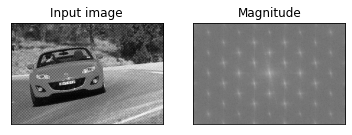

In [22]:
# Calculate the discrete Fourier transform

f=np.fft.fft2(gray)
# f is a 2D fourier transform (FT) that give us the frequency (freq) transform

# Shift the origin of the image domain to the center

fshift=np.fft.fftshift(f)
# fshift is our discrete fourier transform, we shift in order to place the zero freq at the origin

# Calculate magnitude of Fourier transform

magnitude_spectrum=20*np.log(np.abs(fshift))
# magnitude_spectrum is the magnitude of FT, as mentioned in the question we apply a log transform for visability.

# Visualize the image and magnitude

plt.subplot(121), plt.imshow(image, cmap='gray')
plt.title('Input image'), plt.xticks([]),plt.yticks([])
plt.subplot(122), plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude'), plt.xticks([]),plt.yticks([])
plt.show()
# we show the original image along with the magnitude of it's FT

In [23]:
from skimage.feature import peak_local_max
coordinates = peak_local_max(magnitude_spectrum, min_distance=75, exclude_border=0)

print(coordinates) # all the local peaks/maximas
print(coordinates.shape) # number of local maximas

[[333 500]
 [266 400]
 [400 600]
 [266 600]
 [400 400]
 [133 600]
 [533 400]
 [533 600]
 [133 400]
 [266 200]
 [400 800]
 [  0 600]
 [  0 400]
 [467 500]
 [199 500]
 [400 200]
 [266 800]
 [334 700]
 [332 300]
 [266   0]
 [400   0]
 [133 200]
 [533 800]
 [533 200]
 [133 800]
 [  0 200]
 [  0 800]
 [533   0]
 [133   0]
 [665   0]
 [  1   0]
 [467 900]
 [199 100]
 [665 400]
 [665 600]
 [467 100]
 [199 900]
 [200 701]
 [466 299]
 [ 67 700]
 [599 300]
 [ 66 300]
 [600 700]
 [200 301]
 [466 699]
 [ 67 900]
 [599 100]
 [333 101]
 [333 899]
 [ 66 100]
 [600 900]
 [  0 999]
 [265 999]
 [397 999]
 [664 999]
 [664 799]
 [663 199]
 [598 498]
 [ 68 502]
 [131 997]
 [532 999]]
(61, 2)


Text(0.5, 1.0, 'The size of the neighbourhood is 41x41')

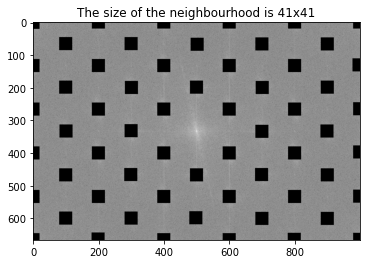

In [24]:
# the white litgh/stars in the magnitude image above is noise that we want to get ride of. we will search 
# for these stars and set them to have a value of 0 (black)

dx,dy = np.shape(image)[0], np.shape(image)[1] # x axis pixels , y axis pixels 
new = magnitude_spectrum.copy() # take a copy of the magnitude spectrum image

L = 20 # window size

for coord in coordinates: # go through all the local maximas/noise
    i = coord[0]
    j = coord[1]
    if i == dx//2 and j == dy//2:   # do not manipulate DC component/center star
        continue
    else:    
        for k1 in np.arange(-L,L,1):     # make a window the size of 2L+1
            for k2 in np.arange(-L,L,1):
                if i+k1>=0 and j+k2>=0 and i+k1<dx and j+k2<dy:   # checking if the pixel is in boundry of image
                    new[i+k1,j+k2]=0                              
                    fshift[i+k1,j+k2]=0        
                    
imshow(new, cmap='gray')
plt.title("The size of the neighbourhood is "+str(2*L+1)+"x"+str(2*L+1))

- min_ dist=100  L=30 : black squares are too big, didnt capture all nosie 
- min_ dist=100  L=20 : black squares are too big, capture all nosie
- min_ dist=10   L=20 : black squares are perfect size, too many black squares
- min_ dist=50   L=20 : black squares are perfect size, captures all noise and some extra stuff
- min_ dist=75   L=20 : black squares are perfect size, capture all nosie

(Text(0.5, 1.0, 'Inverse FT'), ([], []), ([], []))

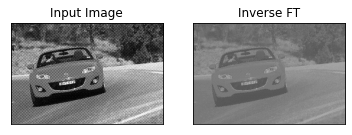

In [25]:
# So we think we cleaned the image....but did we? Convert the image back to the real domain 
# and lets see how much cleaner our image is now

# shift back (we shifted the center before)
f_ishift = np.fft.ifftshift(fshift)

# inverse fft to get the image back 
img_back = ifft2(f_ishift)
# take real part of the inverse FT
img_back = img_back.real

plt.subplot(121),plt.imshow(gray, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_back, cmap = 'gray')
plt.title('Inverse FT'), plt.xticks([]), plt.yticks([])

In [26]:
# Display images

while True:
    cv2.imshow("Original Image | Inverse FT", np.hstack([gray,img_back]))
    # if you press 'Esc', the window closes 
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        cv2.destroyAllWindows()
        break

# the inverse FT image is not in the same pixel intensity range as the original image

In [27]:
img_back.min()

-241.92276077989834

In [28]:
img_back.max()

489.7226908601306

In [29]:
gray.min()

0

In [30]:
gray.max()

255

(Text(0.5, 1.0, 'Intensity Change'), ([], []), ([], []))

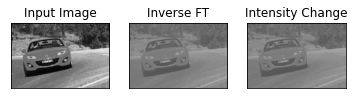

In [31]:
# our image is not in the same intensity range as the original, we know this due to the last 4 code cells
# original is in range [0, 255], restored[-241.92, 489.72]

img=((img_back-np.min(img_back))*1/(np.max(img_back)-np.min(img_back))) # rescale the pixel intensity range

plt.subplot(131),plt.imshow(gray, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(img_back, cmap = 'gray')
plt.title('Inverse FT'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(img, cmap = 'gray')
plt.title('Intensity Change'), plt.xticks([]), plt.yticks([])

In [32]:
# Copy and and scale image resolution
gray_copy = gray.copy()
gray_copy = cv2.resize(gray, (int(gray_copy.shape[1] * 0.5),int(gray_copy.shape[0] * 0.5)))

img_back_copy = img_back.copy()
img_back_copy = cv2.resize(img_back, (int(img_back_copy.shape[1] * 0.5),int(img_back_copy.shape[0] * 0.5)))

img_copy = img.copy()
img_copy = cv2.resize(img, (int(img_copy.shape[1] * 0.5),int(img_copy.shape[0] * 0.5)))

# Display images
while True:
    cv2.imshow("Original Image | Inverse FT | Intensity Change", np.hstack([gray_copy, img_back_copy, img_copy]))
    # if you press 'Esc', the window closes 
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        cv2.destroyAllWindows()
        break
        
# we see the original image which is "dotty", 
# the inverese FT image that seems "bleched", 
# and the intesity change (restored image) that looks normal.
# More importantly, the licence plate for the restored image is legible

Text(0.5, 0, 'Pixel intensity')

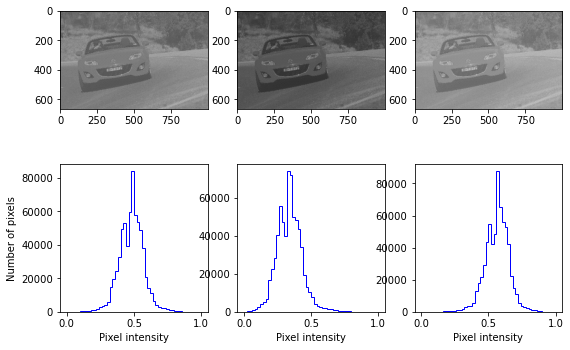

In [33]:
# lets see if brightening or darkening the restored image helps add readablilty 

from skimage import exposure

# set up to display image 
fig=plt.figure(figsize=(9,6))
axes=np.zeros((2,3), dtype=np.object)
axes[0,0]=plt.subplot(2,3,1)
axes[0,1]=plt.subplot(2,3,2)
axes[0,2]=plt.subplot(2,3,3)

axes[1,0]=plt.subplot(2,3,4)
axes[1,1]=plt.subplot(2,3,5)
axes[1,2]=plt.subplot(2,3,6)
ax_im, ax_hist = axes

# Gamma corrected
gamma_corrected = exposure.adjust_gamma(img, 1.5)

# logarithmic corrected
logarithmic_corrected = exposure.adjust_log(img, 1)

# Display image
ax_im[0].imshow(img, cmap='gray')

#Display histogram for original image
ax_hist[0].hist(img.ravel(), bins=50, histtype='step', color='b' )
ax_hist[0].set_xlabel('Pixel intensity')
ax_hist[0].set_ylabel('Number of pixels')

ax_im[1].imshow(gamma_corrected, cmap='gray')
#Display histogram for gamma-corrected image
ax_hist[1].hist(gamma_corrected.ravel(), bins=50, histtype='step', color='b' )
ax_hist[1].set_xlabel('Pixel intensity')

ax_im[2].imshow(logarithmic_corrected, cmap='gray')
#Display histogram for logarithmic_corrected image
ax_hist[2].hist(logarithmic_corrected.ravel(), bins=50, histtype='step', color='b' )
ax_hist[2].set_xlabel('Pixel intensity')



In [34]:
# Playing around with the log and gamma functions, gamma seems to be helpful and log doesn't seem to be helpful.
# A gamma of 1.5 or 2 darkens the image, making the license plate looks like it's "BHT 012" instead of the 
# original assumption of "BHT 012" 

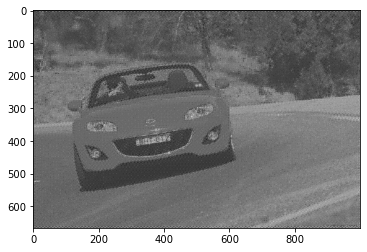

In [35]:
# we are going to normalize and threshold the image to see if it will make the image cleaner

def normalize(intensity, m, E):
    m = m # your threshold, look at the gamma histogram above. looks like 0.3 is the point between the 2 peaks
    I = intensity # image
    dx,dy = np.shape(intensity)[0], np.shape(intensity)[1] # image size in x and y direction
    eps=0.001 # a very small number so our dinominator won't be zero but also small enough to not affect calculations
    cs=np.zeros((dx,dy)) # create an image/matrix full of zeros
    for i in range(dx):
        for j in range(dy):
            cs[i,j]= 1 /(1+m/(I[i,j]+eps))**E # eq for normailization/thresholding
    return cs

g = normalize(img, 0.3, 4)
imshow(g, cmap='gray')

# Display images
while True:
    cv2.imshow("Contrast Filter", g)
    # if you press 'Esc', the window closes 
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        cv2.destroyAllWindows()
        break
        
# We choose a mid point (m) of 0.3 as this is approximatly whe mid point of the 2 local max pixel intensity
# While playing around with E, it seems that the value 4 gave me the best results
# Using this method we got a better contrast, hence a better reconstructed image

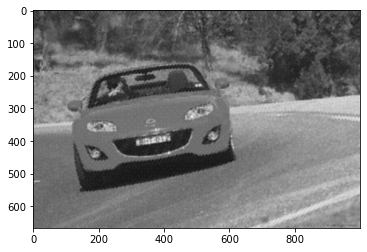

In [19]:
# the previous image is very sharp but the last character on the licence plate could either be a 2 or a z
# we will use a smoothing filter in order to maybe solve this issue

from skimage.filters.rank import mean
from skimage.morphology import disk
from skimage import img_as_ubyte

image = g
img=(image-np.min(image))*255/(np.max(image)-np.min(image))
img = img.astype(np.uint8)
loc_mean = mean(img, disk(3)) # smoothing/contrast filter with a window size of 3
imshow(loc_mean, cmap='gray')

# Display images
while True:
    cv2.imshow("Contrast Filter", loc_mean)
    # if you press 'Esc', the window closes 
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        cv2.destroyAllWindows()
        break

In [37]:
# the smoothing filter wasn't that helpful....
# we can conclude that the car is a mazda miata with the licence plate "BHT 01Z"